## PyTorch Prediction

This notebook uses the trained semantic segmentation network for prediction

In [1]:
from skimage.io import imread as skimread
from pathlib import Path
import torch
import numpy as np
from tnia.deeplearning.dl_helper import quantile_normalization
from torchvision import transforms
from torchvision.transforms import v2

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup Paths

In [11]:

#tnia_images_path = Path("D:/images/tnia-python-images")
tnia_images_path = Path(r'/home/bnorthan/images/tnia-python-images')
parent_path =Path(r'D:\images\tnia-python-images\imagesc\2024_08_15_plant_roots') 


images_path = parent_path 
patch_path = parent_path / 'patches'
labels_path = parent_path / 'labels'
model_path = parent_path / 'models'

test_name = r'006_001.jpg'

testim = skimread(images_path  / test_name)
testim = skimread(r'D:\images\tnia-python-images\imagesc\2024_08_15_plant_roots\labels\input0\006_001_0.tif') 
origim = np.copy(testim)
print(testim.shape)
axes = 'YX'

testim2 = skimread(r'D:\images\tnia-python-images\imagesc\2024_08_15_plant_roots\patches\input0\grid_1.tif')

(750, 738, 3)


## Load model

In [12]:
model = torch.load(model_path / 'model1')
temp = model.to('cuda')

In [13]:
device = torch.device("cuda")

## Convert image to tensor...

and predict output segmentation

In [14]:
testim = origim[50:50+196, 170:170+196, :]

testim.shape, testim.shape, testim.min(), testim.max()

((196, 196, 3), (196, 196, 3), 0, 198)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


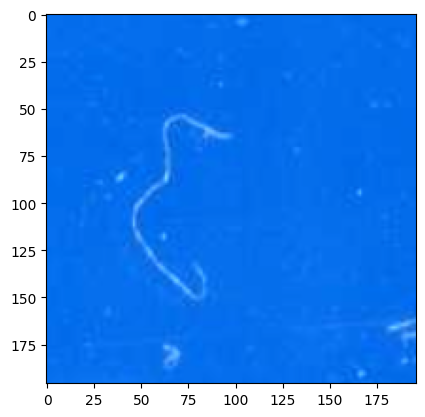

In [15]:
testim = testim2
import matplotlib.pyplot as plt
plt.imshow(testim)

In [16]:
testim_ = testim.copy().astype(np.float32)

'''
if axes == 'YXC':
    for i in range(1):
        testim_[:,:,i] = quantile_normalization(
            testim[:,:,i],
            quantile_low=0.01,
            quantile_high=0.998,
            clip=True).astype(np.float32)
else:
    testim_ = quantile_normalization(
        testim_,
        quantile_low=0.01,
        quantile_high=0.998,
        clip=True).astype(np.float32)
'''

#testim_ = quantile_normalization(testim, quantile_low = 0.01, quantile_high = 0.998, clip = False).astype(np.float32)

tensor_transform = transforms.Compose([
    v2.ToTensor(),
])
x = tensor_transform(testim_)
x = x.unsqueeze(0).to(device)
#x = torch.from_numpy(testim_).to(device)

print(x.shape)
y = model(x)


torch.Size([1, 3, 196, 196])


In [17]:
testim2.min(), testim2.max(), testim2.mean()

(0.0, 1.2583319, 0.46216983)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction info -5.491945 2.9827158 -2.4947934


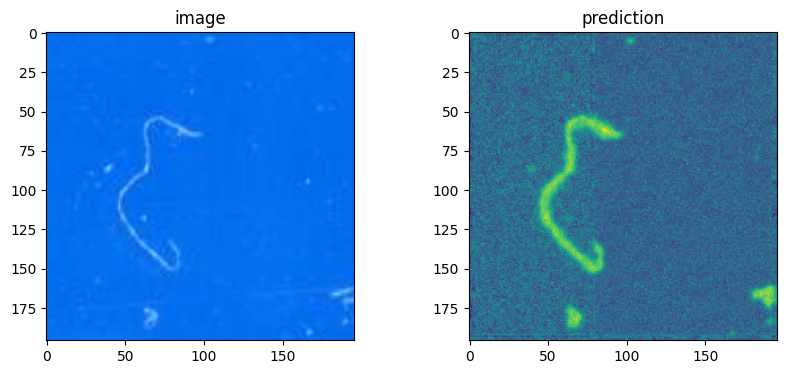

In [18]:
from tnia.plotting.plt_helper import imshow_multi2d

image = testim_
prediction = y.cpu().detach().numpy()[0,0,:,:]
print('prediction info', prediction.min(), prediction.max(), prediction.mean())

fig = imshow_multi2d([image, prediction], ['image', 'prediction'], 1, 2)

In [81]:
import napari
viewer = napari.Viewer()
viewer.add_image(image, name='image')
viewer.add_image(prediction, name='prediction')

<Image layer 'prediction' at 0x21535f38430>

## Find bounding boxes of labels

Load the bounding boxes for any labels drawn on this image.  This is useful to see self-prediction (prediction on areas that were labeld) vs validation prediction (prediction on areas of image that were not labeled)

In [60]:
# search for ROI
import json

labels_image_path = labels_path / 'input0'

json_names = list(Path(labels_image_path).glob('*.json'))
base_name = test_name.split('.')[0]
json_names_ = [x for x in json_names if base_name in x.name]

test_ = test_name.split('.')[0]

rois=[]

for json_name in json_names_:
    # open json
    with open(json_name, 'r') as f:
        json_ = json.load(f)
        print(json_)
        
        y1= json_['bbox'][0]
        x1= json_['bbox'][1]
        y2= json_['bbox'][2]
        x2= json_['bbox'][3]
        rois.append([[x1, y1], [x2, y2]])
        


{'base_name': '006_001_0', 'bbox': [17, 4, 755, 754]}


## View in napari

View image, prediction and bounding box in napari

In [61]:
import napari
viewer = napari.Viewer()
viewer.add_image(testim_, name='testim')
viewer.add_image(y.cpu().detach()[0, 0].numpy(), name='prediction')
binary = y.cpu().detach()[0, 0].numpy() > 0.5
binary = binary.astype(np.uint8)
binary = binary*2
viewer.add_labels(binary, name='prediction binary')
boxes_layer = viewer.add_shapes(
            name="Label box",
            face_color="transparent",
            edge_color="green",
            edge_width=2,
        )

boxes_layer.add(rois)